In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json


In [2]:
# Fixing the random seed for reproducibility
np.random.seed(42)

# Sigmoid function for smooth transition
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Load real temperature data from CSV
def load_temperature_data(filepath):
    """
    Load temperature data from a CSV file.
    Assumes the CSV has columns 'Date', 'Temperature', and other weather-related variables.
    """
    try:
        # Load the CSV file
        temp_data = pd.read_csv(filepath, parse_dates=['Date'])
        
        # Set 'Date' as the index
        temp_data.set_index('Date', inplace=True)
        
        # Rename columns for consistency (optional)
        temp_data.rename(columns={
            'Temperature': 'Temperature',
            'Feels like': 'FeelsLike',
            'Pressure': 'Pressure',
            'Humidity': 'Humidity',
            'Minimun Temp (F)': 'MinTemp',
            'Maximum Temp (F)': 'MaxTemp',
            'Wind Speed': 'WindSpeed',
            'Wind Degree': 'WindDegree',
            'Rain 1h': 'Rain1h',
            'Clouds All': 'Clouds',
            'Weather Id': 'WeatherId',
            'Weather Main': 'WeatherMain',
            'Weather Description': 'WeatherDescription',
            'Weather Icon': 'WeatherIcon'
        }, inplace=True)
        
        return temp_data
    except Exception as e:
        print(f"Error loading temperature data: {e}")
        return None



In [3]:
def generate_load_profile(total_energy_kWh, temperature_data, parameters):
    """
    Generate a synthetic load demand profile based on total energy use, temperature data, and parameters.
    Incorporates humidity, wind speed, and rainfall for improved realism.
    """
    # Extract relevant columns
    temperature = temperature_data['Temperature'].values
    humidity = temperature_data['Humidity'].values
    wind_speed = temperature_data['WindSpeed'].values

    # Get the start date and number of observations from the temperature data
    start_date = temperature_data.index[0]  # First timestamp in the temperature data
    num_observations = len(temperature_data)  # Number of rows in the temperature data

    # Calculate base load per hour
    hours_per_year = 24 * 365
    base_load_per_hour = total_energy_kWh / hours_per_year  # Base load in kWh per hour

    # Create time series and date range based on the temperature data
    time = np.arange(0, num_observations)
    date_range = pd.date_range(start=start_date, periods=num_observations, freq="h")

    # Create base demand with total energy use factored in
    base_demand = (base_load_per_hour +
                   parameters['daily_fluctuation'] * np.sin(2 * np.pi * ((time % 24 + parameters['daily_phase_shift']) / 24)) +
                   parameters['seasonal_fluctuation'] * np.sin(2 * np.pi * (time / (24 * 365 / parameters['seasonal_frequency']) + parameters['seasonal_phase_shift'] / 365)))

    # Adjust demand for temperature
    demand_adjusted_for_temp = base_demand + parameters['temperature_variation'] * (temperature - parameters['comfort_temp'])

    # Adjust demand for humidity
    demand_adjusted_for_humidity = demand_adjusted_for_temp + parameters['humidity_variation'] * (humidity - parameters['comfort_humidity'])

    # Adjust demand for wind speed
    demand_adjusted_for_wind = demand_adjusted_for_humidity + parameters['wind_speed_variation'] * wind_speed

    # Add random noise (day/night, weekday/weekend)
    random_noise = np.zeros_like(time)
    for i, hour in enumerate(date_range):
        is_weekend = (hour.weekday() >= 5 and not parameters['weekdays_include_saturday']) or (hour.weekday() == 6)
        is_daytime = hour.hour >= parameters['day_night_threshold'] and hour.hour < 19
        
        if is_daytime:  # Daytime
            if is_weekend:
                random_noise[i] = np.random.normal(0, parameters['sigma_weekend'] * parameters['weekend_smoothing_factor'])
            else:
                random_noise[i] = np.random.normal(0, parameters['sigma_day'])
        else:  # Nighttime
            if is_weekend:
                random_noise[i] = np.random.normal(0, parameters['sigma_weekend'] * parameters['weekend_smoothing_factor'])
            else:
                random_noise[i] = np.random.normal(0, parameters['sigma_night'])

    # Sigmoid-based weekend smoothing
    def smooth_transition(hour, transition_start, transition_end):
        transition_range = np.linspace(-6, 6, parameters['transition_hours'] * 2)
        transition_weights = sigmoid(transition_range)
        
        if transition_start <= hour < transition_end:
            return transition_weights[hour - transition_start]
        return 1

    for i, hour in enumerate(date_range):
        is_weekend = (hour.weekday() >= 5 and not parameters['weekdays_include_saturday']) or (hour.weekday() == 6)

        # Sigmoid smoothing between Friday and Saturday, and Sunday to Monday
        if hour.weekday() == 4 and hour.hour >= (24 - parameters['transition_hours']):
            # Friday evening transition to Saturday
            transition_factor = smooth_transition(hour.hour, 24 - parameters['transition_hours'], 24)
            demand_adjusted_for_wind[i] *= (1 - parameters['weekend_multiplier'] * transition_factor)
        elif hour.weekday() == 5 and hour.hour < parameters['transition_hours']:
            # Saturday morning transition from Friday
            transition_factor = smooth_transition(hour.hour, 0, parameters['transition_hours'])
            demand_adjusted_for_wind[i] *= (1 - parameters['weekend_multiplier'] * transition_factor)

        elif hour.weekday() == 6 and hour.hour >= (24 - parameters['transition_hours']):
            # Sunday evening transition to Monday
            transition_factor = smooth_transition(hour.hour, 24 - parameters['transition_hours'], 24)
            demand_adjusted_for_wind[i] *= parameters['weekend_multiplier'] + (1 - parameters['weekend_multiplier']) * transition_factor
        elif hour.weekday() == 0 and hour.hour < parameters['transition_hours']:
            # Monday morning transition from Sunday
            transition_factor = smooth_transition(hour.hour, 0, parameters['transition_hours'])
            demand_adjusted_for_wind[i] *= parameters['weekend_multiplier'] + (1 - parameters['weekend_multiplier']) * transition_factor

        # Apply the daily fluctuation for weekdays or weekends
        daily_fluctuation = parameters['daily_fluctuation'] if not is_weekend else parameters['weekend_daily_fluctuation']
        demand_adjusted_for_wind[i] += daily_fluctuation * np.sin(2 * np.pi * ((hour.hour % 24 + parameters['daily_phase_shift']) / 24))

        if is_weekend:  # Saturday and Sunday (based on settings)
            demand_adjusted_for_wind[i] *= parameters['weekend_multiplier']

    # Synthetic demand with randomness
    synthetic_demand = demand_adjusted_for_wind + random_noise
    
    # Calculate the total synthetic demand and the scaling factor
    total_synthetic_demand = synthetic_demand.sum()
    scaling_factor = total_energy_kWh / total_synthetic_demand

    # Apply the scaling factor to adjust the synthetic demand
    adjusted_synthetic_demand = synthetic_demand * scaling_factor

    # Create DataFrame with synthetic demand and additional variables
    df = pd.DataFrame({
        'Timestamp': date_range,
        'Temperature': temperature,
        'Humidity': humidity,
        'WindSpeed': wind_speed,
        'Synthetic Load Demand (kWh)': adjusted_synthetic_demand
    })
    df.set_index('Timestamp', inplace=True)

    return df

In [153]:
# Parameters for synthetic data generation
parameters = {
    "hours_per_day": 24,
    "days_per_year": 365,
    "daily_fluctuation": 60,  # kWh, daily fluctuation for weekdays
    "weekend_daily_fluctuation": 20,  # Weekend daily fluctuation
    "seasonal_fluctuation": 120,  # kWh, seasonal fluctuation
    "temperature_variation": 3,  # Effect of temperature
    "comfort_temp": 22,  # Celsius
    "sigma_day": 10,  # Random noise scale for day
    "sigma_night": 1,  # Random noise scale for night
    "sigma_weekend": 5,  # Noise on weekends
    "weekend_multiplier": 0.8,  # Lower demand on weekends
    "day_night_threshold": 7,  # Define 7 AM to 7 PM as "day"
    "weekend_smoothing_factor": 0.1,  # Smoothing weekend variations
    "weekdays_include_saturday": False,  # Include Saturday as weekday
    "transition_hours": 1,  # Number of hours for smooth transitions
    "daily_phase_shift": 0,  # Shift daily peak in hours (positive = later, negative = earlier)
    "seasonal_phase_shift": -165,  # Shift seasonal peak in days (positive = later, negative = earlier)
    "seasonal_frequency": 2,  # Example: 2 peaks per year (default is 1)
    "humidity_variation": 0.3,  # Influence of humidity on load demand
    "comfort_humidity": 50,  # Comfortable humidity level (%)
    "wind_speed_variation": 0.05,  # Influence of wind speed on load demand
}



Total annual energy use: 3834447.51 kWh


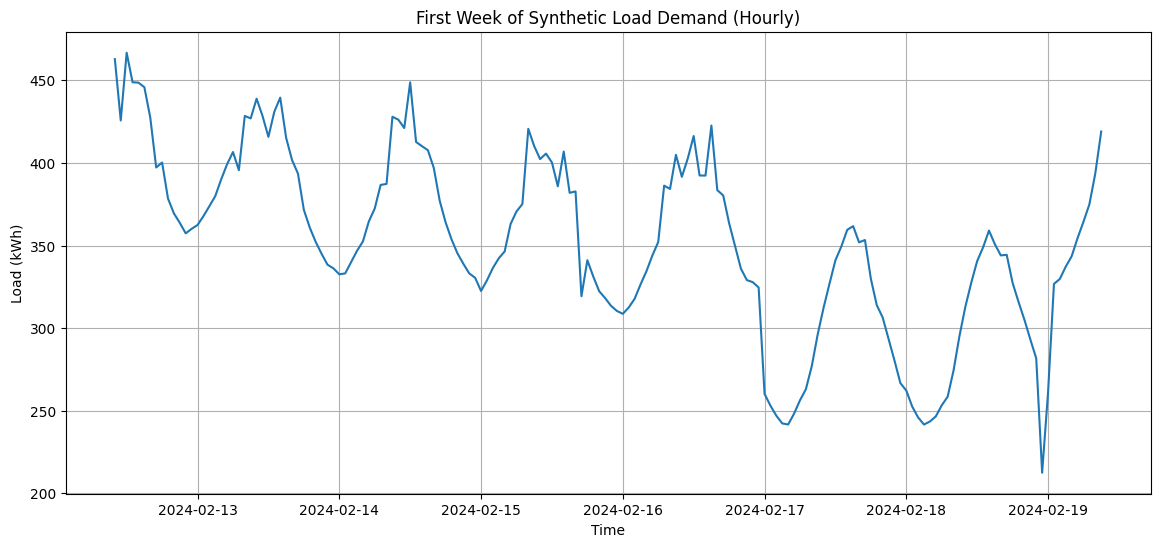

In [154]:
# New parameters for energy use intensity and building area
EUI_GJ_per_m2_per_year = 1.16  # Energy Use Intensity in GJ/m²/year (example value)
building_area_m2 = 11900  # Area of the building in square meters
city_name = 'calgary'

# Calculate total annual energy use in kWh
total_energy_GJ = EUI_GJ_per_m2_per_year * building_area_m2  # Total energy use in GJ
total_energy_kWh = total_energy_GJ * 277.778  # Convert GJ to kWh
print(f"Total annual energy use: {total_energy_kWh:.2f} kWh")

# Load real temperature data
temperature_data = load_temperature_data('weather_data/openweather_data_calgary.csv')  # Replace with your CSV file path

# Generate synthetic load demand profile
df = generate_load_profile(total_energy_kWh, temperature_data, parameters)

# Convert the values to strings for file names (replacing any special characters if necessary)
EUI_str = str(EUI_GJ_per_m2_per_year).replace('.', '_')
area_str = str(building_area_m2)

# Save the parameters and the data with the variable values in the file names
parameters_file_name = f'synthetic_load_data/synthetic_load_data_parameters_EUI_{EUI_str}_area_{area_str}_{city_name}.json'
load_demand_file_name = f'synthetic_load_data/synthetic_load_demand_EUI_{EUI_str}_area_{area_str}_{city_name}.csv'

with open(parameters_file_name, 'w') as f:
    json.dump(parameters, f, indent=4)

df.to_csv(load_demand_file_name)

# Plot to verify (for example, first week)
plt.figure(figsize=(14, 6))
plt.plot(df.index[:24*7], df['Synthetic Load Demand (kWh)'][:24*7], label='Synthetic Load Demand (First Week)')
plt.title('First Week of Synthetic Load Demand (Hourly)')
plt.xlabel('Time')
plt.ylabel('Load (kWh)')
plt.grid(True)
plt.show()

In [155]:
df.head()

,Temperature,Humidity,WindSpeed,Synthetic Load Demand (kWh)
Timestamp,,,,
2024-02-12 10:00:00,1.19,73,4.02,462.869770
2024-02-12 11:00:00,1.86,68,3.13,425.721927
2024-02-12 12:00:00,2.72,56,4.47,466.729809
2024-02-12 13:00:00,2.54,49,7.72,448.854024
2024-02-12 14:00:00,2.01,48,3.58,448.615342


In [156]:
df.describe()

,Temperature,Humidity,WindSpeed,Synthetic Load Demand (kWh)
count,8510.000000,8510.000000,8510.000000,8510.000000
mean,5.767722,67.836193,2.811826,450.581376
std,11.352074,19.560236,1.922674,115.868884
min,-25.770000,16.000000,0.000000,159.229350
25%,-1.920000,53.000000,1.340000,357.369065
50%,6.115000,71.500000,2.370000,444.398989
75%,14.047500,85.000000,3.580000,541.156016
max,34.630000,100.000000,18.520000,715.093399


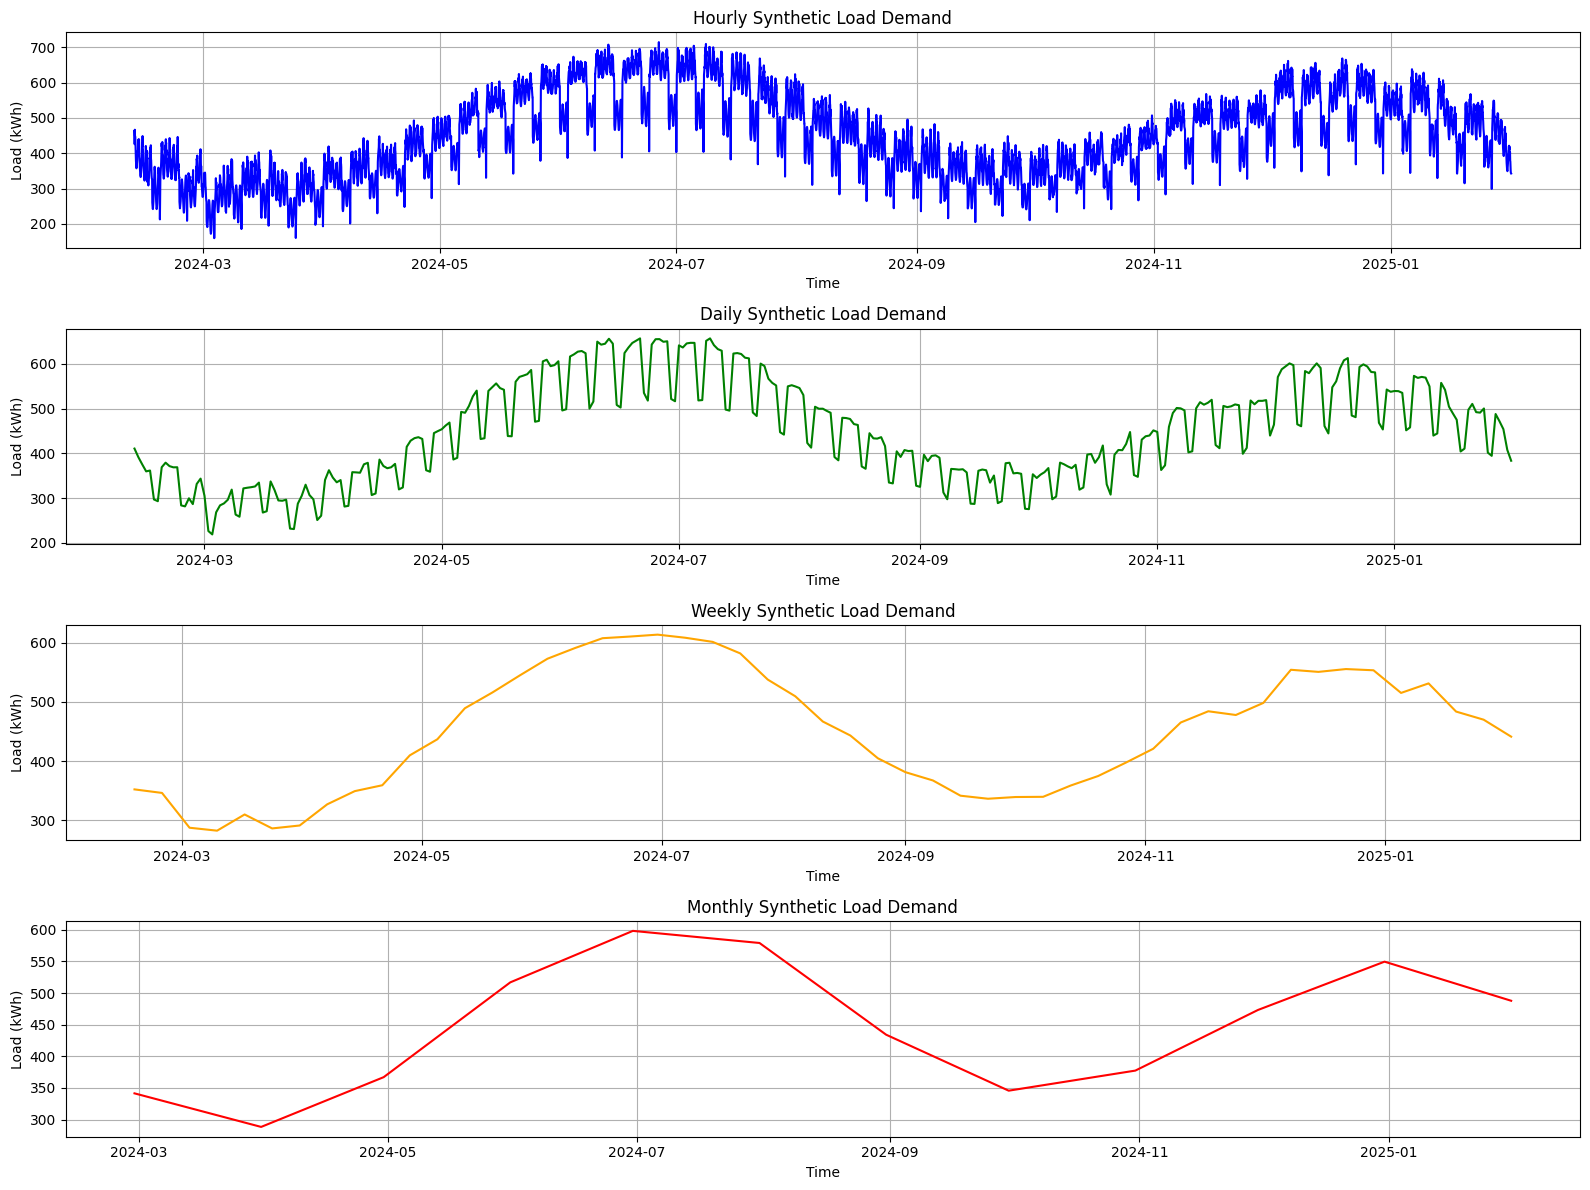

In [157]:
# Resample the data for different time scales
hourly_data = df['Synthetic Load Demand (kWh)'].resample('h').mean()
daily_data = df['Synthetic Load Demand (kWh)'].resample('D').mean()
weekly_data = df['Synthetic Load Demand (kWh)'].resample('W').mean()
monthly_data = df['Synthetic Load Demand (kWh)'].resample('ME').mean()

# Plot the data
plt.figure(figsize=(16, 12))

# Hourly data plot
plt.subplot(4, 1, 1)
plt.plot(hourly_data.index, hourly_data, color='blue', label='Hourly Demand')
plt.title('Hourly Synthetic Load Demand')
plt.xlabel('Time')
plt.ylabel('Load (kWh)')
plt.grid(True)

# Daily data plot
plt.subplot(4, 1, 2)
plt.plot(daily_data.index, daily_data, color='green', label='Daily Demand')
plt.title('Daily Synthetic Load Demand')
plt.xlabel('Time')
plt.ylabel('Load (kWh)')
plt.grid(True)

# Weekly data plot
plt.subplot(4, 1, 3)
plt.plot(weekly_data.index, weekly_data, color='orange', label='Weekly Demand')
plt.title('Weekly Synthetic Load Demand')
plt.xlabel('Time')
plt.ylabel('Load (kWh)')
plt.grid(True)

# Monthly data plot
plt.subplot(4, 1, 4)
plt.plot(monthly_data.index, monthly_data, color='red', label='Monthly Demand')
plt.title('Monthly Synthetic Load Demand')
plt.xlabel('Time')
plt.ylabel('Load (kWh)')
plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


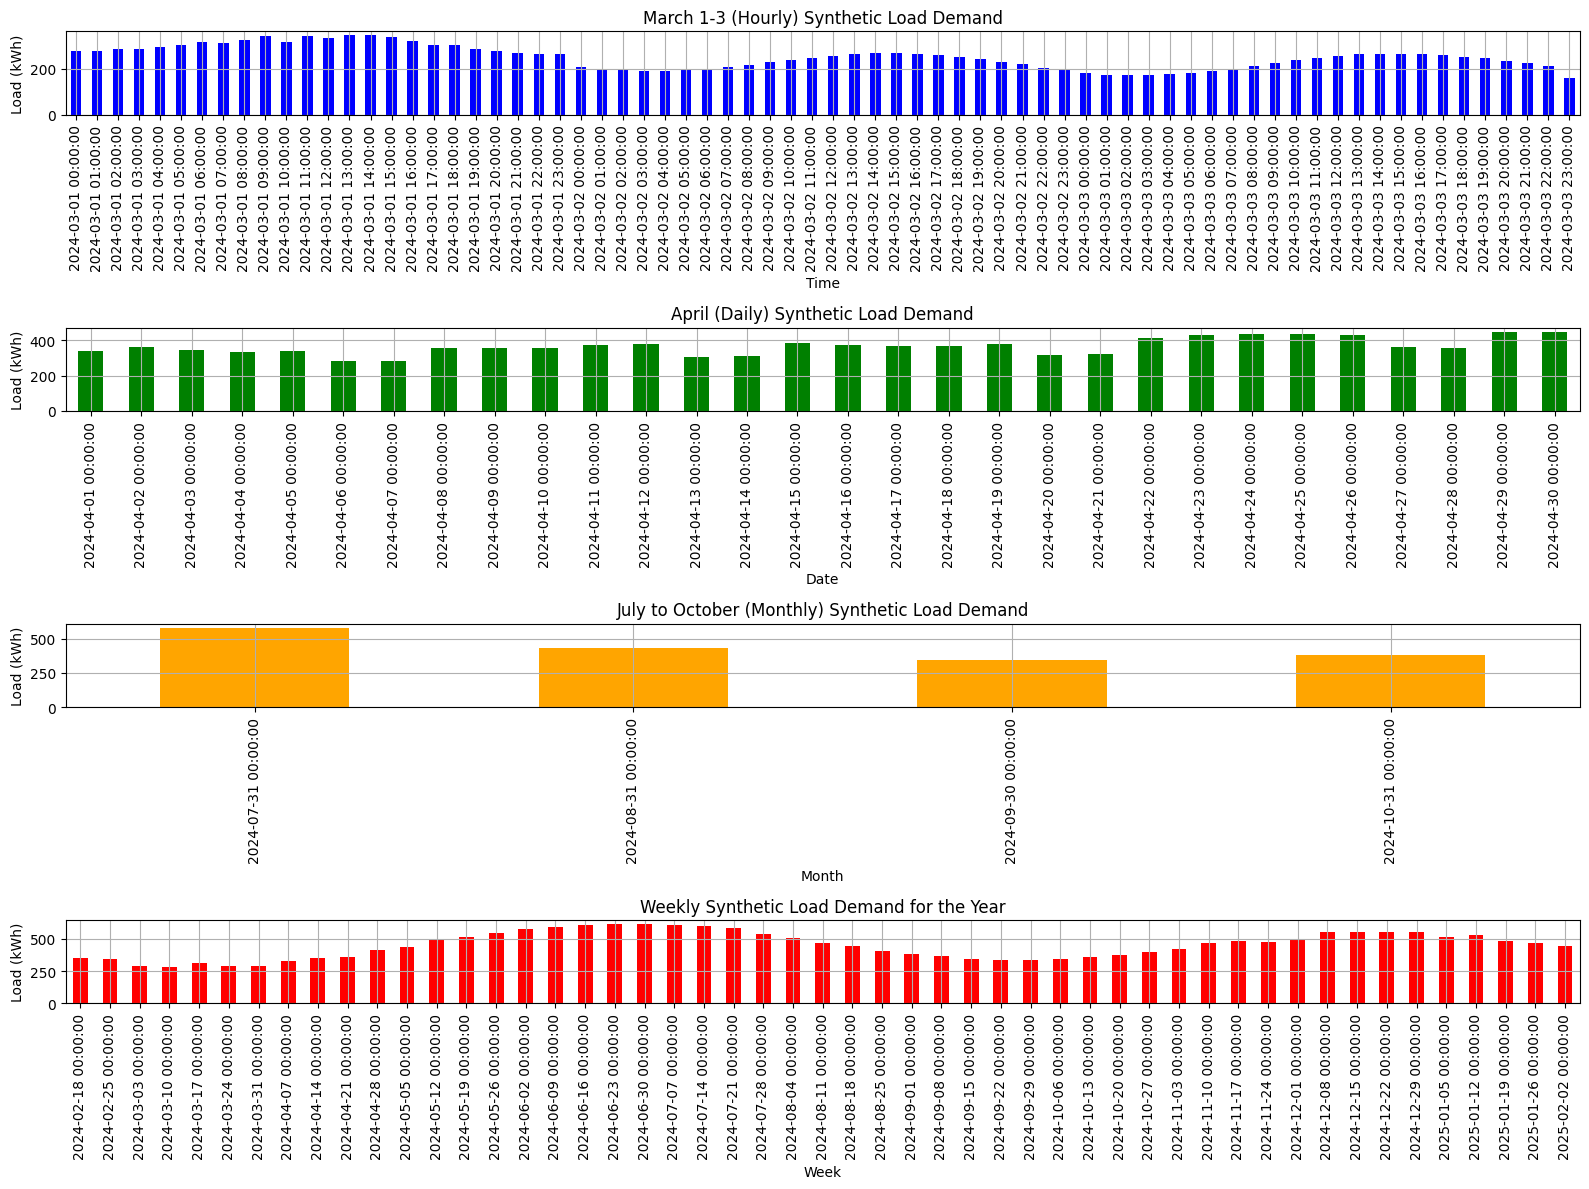

In [158]:
# Select the first three days of March hourly
march_3days = df['Synthetic Load Demand (kWh)']['2024-03-01':'2024-03-03'].resample('h').mean()

# Select the entire April daily
april_data = df['Synthetic Load Demand (kWh)']['2024-04-01':'2024-04-30'].resample('D').mean()

# Select from July to October monthly
jul_oct_data = df['Synthetic Load Demand (kWh)']['2024-07-01':'2024-10-31'].resample('ME').mean()

# Weekly data for the entire year
weekly_data = df['Synthetic Load Demand (kWh)'].resample('W').mean()

# Plot the data
plt.figure(figsize=(16, 12))

# Plot the first three days of March hourly
plt.subplot(4, 1, 1)
march_3days.plot(kind='bar', color='blue', label='March 1-3 Hourly Demand')
plt.title('March 1-3 (Hourly) Synthetic Load Demand')
plt.xlabel('Time')
plt.ylabel('Load (kWh)')
plt.grid(True)

# Plot the entire April daily
plt.subplot(4, 1, 2)
april_data.plot(kind='bar', color='green', label='April Daily Demand')
plt.title('April (Daily) Synthetic Load Demand')
plt.xlabel('Date')
plt.ylabel('Load (kWh)')
plt.grid(True)

# Plot from July to October monthly
plt.subplot(4, 1, 3)
jul_oct_data.plot(kind='bar', color='orange', label='July-October Monthly Demand')
plt.title('July to October (Monthly) Synthetic Load Demand')
plt.xlabel('Month')
plt.ylabel('Load (kWh)')
plt.grid(True)

# Plot the entire year weekly
plt.subplot(4, 1, 4)
weekly_data.plot(kind='bar', color='red', label='Weekly Demand for Entire Year')
plt.title('Weekly Synthetic Load Demand for the Year')
plt.xlabel('Week')
plt.ylabel('Load (kWh)')
plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [159]:
diff_synthetic_data = df['Synthetic Load Demand (kWh)'].sum() - total_energy_kWh # Difference in total energy use in kWh, synthetic data vs. calculated (reference), should be close to zero
print(f"Difference in total energy use: {diff_synthetic_data:.2f} kWh")

error = diff_synthetic_data / total_energy_kWh * 100  # Error percentage
print(f"Error percentage: {error:.2f}%")

Difference in total energy use: 0.00 kWh
Error percentage: 0.00%
